# Pokemon type classifier

This project takes a dataset with Pokémon sprites and trains a CNN to classify whether a Pokémon belongs to a certain type (e.g. water: true or false). It is meant as a demo to show how DVC can be used in deep learning scenarios.

## Imports and parameters

In [1]:
import math
import os
import re
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss, accuracy_score, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tqdm import tqdm
import yaml

## Define variables

In [2]:
SEED: int = 42
POKEMON_TYPE_TRAIN: str = "Water"
    
SOURCE_DIRECTORY: str = "data/external"
DESTINATION_DIRECTORY: str = "data/processed"
TRAIN_DATA_IMAGES: str = "images"
TRAIN_DATA_LABELS: str = "stats/pokemon-gen-1-8.csv"

MODEL_TEST_SIZE: float = 0.2
MODEL_LEARNING_RATE: float = 0.001
MODEL_EPOCHS: int = 10
MODEL_BATCH_SIZE: int = 120

## Util: find root of Git project

In [3]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Make sure the right directory structure exists

In [4]:
try:
    os.mkdir(PROJECT_ROOT / DESTINATION_DIRECTORY)
except:
    None
    
try:
    os.mkdir(PROJECT_ROOT / "outputs")
except:
    None

## Data preprocessing

In [6]:
# Process Pokémon and one-hot encode the types

def preprocess_training_labels(dataset) -> pd.DataFrame:
    pokemon = pd.read_csv(PROJECT_ROOT / SOURCE_DIRECTORY / dataset)
    pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

    # Create one-hot columns for each type
    types = set(pokemon["type1"])
    for t in types:
        pokemon["is" + str(t).capitalize()] = 0

    # Iterate over Pokémon
    for i, p in pokemon.iterrows():

        #  Set one-hot columns to 1 for relevant types
        pokemon.loc[i, "is" + p["type1"].capitalize()] = 1

        if not pd.isna(p["type2"]):
            pokemon.loc[i, "is" + p["type2"].capitalize()] = 1
            
    # Save output    
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv', index=False)            
    return(pokemon)

pokemon = preprocess_training_labels(TRAIN_DATA_LABELS)
pokemon.head()

,pokedex_number,name,type1,type2,isFairy,isSteel,isNormal,isElectric,isDragon,isFire,...,isFighting,isGrass,isIce,isGround,isWater,isBug,isPoison,isRock,isDark,isPsychic
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,4,Charmander,fire,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Charmeleon,fire,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Process image data

def preprocess_training_data(dataset) -> pd.DataFrame:

    data_directory_images = PROJECT_ROOT / SOURCE_DIRECTORY / dataset
    output_directory = PROJECT_ROOT / DESTINATION_DIRECTORY / "pokemon"

    pokemon = pd.read_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv')
    pokemon["imagePath"] = np.nan

    # Remove processed folder and create empty new one
    try:
        shutil.rmtree(output_directory)
        os.mkdir(output_directory)
    except:
        os.mkdir(output_directory)

    # Copy images to processed folder
    for image in os.listdir(data_directory_images):
        pokemon_id = image.split('.')[0]

        # Add leading zeroes to ID
        while len(pokemon_id) < 3:
            pokemon_id = "0" + pokemon_id

        # Images with no variety (e.g. "211.png")
        if pokemon_id.isnumeric():

            # Copy to processed folder
            src = data_directory_images / image
            dst = os.path.join(output_directory, pokemon_id + ".png")
            shutil.copyfile(src, dst)

            # Set image path in data frame
            pokemon.loc[pokemon["pokedex_number"] == int(pokemon_id), 'imagePath'] = dst

    # Drop Pokemon without image path
    pokemon = pokemon.dropna(subset=["imagePath"])
    
    # Save pokemon.csv with image paths
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon-with-image-paths.csv', index=False)
    
    return(pokemon)


pokemon = preprocess_training_data(TRAIN_DATA_IMAGES)
pokemon.head()

,pokedex_number,name,type1,type2,isFairy,isSteel,isNormal,isElectric,isDragon,isFire,...,isGrass,isIce,isGround,isWater,isBug,isPoison,isRock,isDark,isPsychic,imagePath
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,C:\Users\franc\Documents\HandsOn\dtc-workshop\...
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,C:\Users\franc\Documents\HandsOn\dtc-workshop\...
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,C:\Users\franc\Documents\HandsOn\dtc-workshop\...
3,4,Charmander,fire,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,C:\Users\franc\Documents\HandsOn\dtc-workshop\...
4,5,Charmeleon,fire,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,C:\Users\franc\Documents\HandsOn\dtc-workshop\...


## Load training data and create split

In [8]:
# Load training images
def load_training_data(labels) -> np.array:
    train_image = []

    for i in tqdm(range(labels.shape[0])):

        img = tf.keras.utils.load_img(labels.iloc[i]["imagePath"], color_mode='rgba')
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)
    
    return(X)

X = load_training_data(pokemon)
X.shape

100%|██████████| 801/801 [00:05<00:00, 150.92it/s]


(801, 475, 475, 4)

In [9]:
# Create labels

def create_labels(labels):
    return(pokemon[["is" + POKEMON_TYPE_TRAIN]])

y = create_labels(pokemon)

In [11]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=MODEL_TEST_SIZE, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


In [12]:
# Save train and test data

pickle.dump(X, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X.pckl", "wb"))
pickle.dump(X_train, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X_train.pckl", "wb"))
pickle.dump(X_test, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X_test.pckl", "wb"))

pickle.dump(y, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y.pckl", "wb"))
pickle.dump(y_train, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y_train.pckl", "wb"))
pickle.dump(y_test, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y_test.pckl", "wb"))

## Define model and train

In [13]:
def compile_model(model_image_size_x, model_image_size_y):
    img_input = layers.Input(shape=(model_image_size_x, model_image_size_y, 4))

    model = Sequential()

    model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(model_image_size_x, model_image_size_y, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))

    model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Dropout(0.2))

    model.add(Dense(8, activation="relu"))

    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(1, activation="sigmoid"))

    # Legacy needed for M1/M2
    optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001) #Adam, RMSprop or SGD

    model.compile(
        loss='binary_crossentropy'
        , optimizer=optimizer
        , metrics=[keras.metrics.AUC()]
    )

    model.summary()

    return(model)

model_image_size_x = len(X[1])
model_image_size_y = len(X[2])

model = compile_model(model_image_size_x, model_image_size_y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 471, 471, 4)       404       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 235, 235, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 235, 235, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 231, 231, 4)       404       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 115, 115, 4)      0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 115, 115, 8)       4

In [14]:
# Now train the model

def train_estimator(model):
    def calculate_class_weights(y_train):
        ratio_true = sum(y_train["is" + POKEMON_TYPE_TRAIN] == 1) / len(y_train["is" + POKEMON_TYPE_TRAIN])
        ratio_false = sum(y_train["is" + POKEMON_TYPE_TRAIN] != 1) / len(y_train["is" + POKEMON_TYPE_TRAIN])

        return {0: ratio_true, 1: ratio_false}


    estimator = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        class_weight= calculate_class_weights(y_train),
                        epochs=MODEL_EPOCHS, 
                        batch_size=MODEL_BATCH_SIZE,
                        verbose=1)

    return(estimator)

estimator = train_estimator(model)

Epoch 1/10
6/6 [==============================] - 95s 13s/step - loss: 0.2660 - auc: 0.6350 - val_loss: 0.8432 - val_auc: 0.5811
Epoch 2/10
6/6 [==============================] - 46s 7s/step - loss: 0.2290 - auc: 0.7963 - val_loss: 0.6326 - val_auc: 0.6054
Epoch 3/10
6/6 [==============================] - 66s 11s/step - loss: 0.2095 - auc: 0.8497 - val_loss: 0.7140 - val_auc: 0.5909
Epoch 4/10
6/6 [==============================] - 70s 10s/step - loss: 0.1915 - auc: 0.8960 - val_loss: 0.9127 - val_auc: 0.5892
Epoch 5/10
6/6 [==============================] - 43s 7s/step - loss: 0.1811 - auc: 0.9028 - val_loss: 0.6563 - val_auc: 0.5875
Epoch 6/10
6/6 [==============================] - 52s 8s/step - loss: 0.1601 - auc: 0.9464 - val_loss: 0.6104 - val_auc: 0.5821
Epoch 7/10
6/6 [==============================] - 55s 9s/step - loss: 0.1501 - auc: 0.9588 - val_loss: 0.6013 - val_auc: 0.5652
Epoch 8/10
6/6 [==============================] - 37s 6s/step - loss: 0.1488 - auc: 0.9577 - val_loss

## Plot training history and save model

INFO:tensorflow:Assets written to: C:\Users\franc\Documents\HandsOn\dtc-workshop\outputs\model\assets


INFO:tensorflow:Assets written to: C:\Users\franc\Documents\HandsOn\dtc-workshop\outputs\model\assets


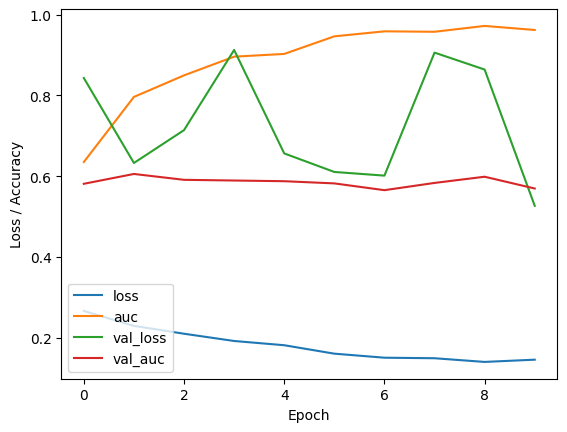

In [15]:
def save_estimator(estimator):
    # Training history
    plt.figure()
    plt.ylabel('Loss / Accuracy')
    plt.xlabel('Epoch')

    for k in estimator.history.keys():
        plt.plot(estimator.history[k], label = k) 
    plt.legend(loc='best')

    plt.savefig(PROJECT_ROOT / "outputs" / "train_history.png", dpi=150, bbox_inches='tight', pad_inches=0)

    # Save model itself
    model.save(PROJECT_ROOT / "outputs" / "model")
    
save_estimator(estimator)

## Validation

0.6902935


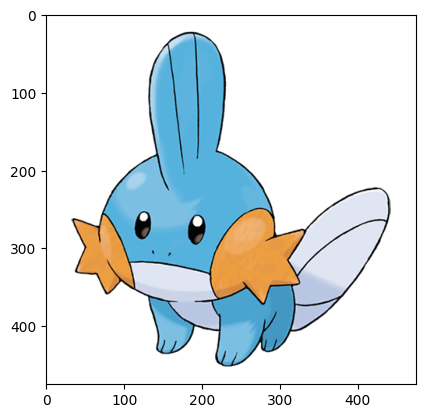

In [16]:
# Try on one Pokémon
def predict_pokemon(id: str, verbose=0):
    
    id = id.zfill(3)
    
    img = tf.keras.utils.load_img(PROJECT_ROOT/DESTINATION_DIRECTORY/'pokemon'/f'{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

In [17]:
# Load model
model = keras.models.load_model(PROJECT_ROOT / "outputs" / "model")

# Load data
X = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X.pckl").read_bytes())
X_train = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X_train.pckl").read_bytes())
X_test = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X_test.pckl").read_bytes())

y = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y.pckl").read_bytes())
y_train = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y_train.pckl").read_bytes())
y_test = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y_test.pckl").read_bytes())


In [18]:
# Predict all Pokémon
predictions = model.predict(X) > 0.5

26/26 [==============================] - 10s 230ms/step


In [19]:
# Calculate metrics
metrics = {}

metrics["acc"] = float(accuracy_score(y, predictions))
metrics["precision"] = float(precision_score(y, predictions))
metrics["recall"] = float(recall_score(y, predictions))
metrics["f1"] = float(f1_score(y, predictions))

# Save metrics
with open(PROJECT_ROOT / "outputs" / "metrics.yaml", 'w') as file:
    yaml.dump(metrics, file, default_flow_style=False)
    
print(metrics)

{'acc': 0.9438202247191011, 'precision': 0.9056603773584906, 'recall': 0.732824427480916, 'f1': 0.810126582278481}


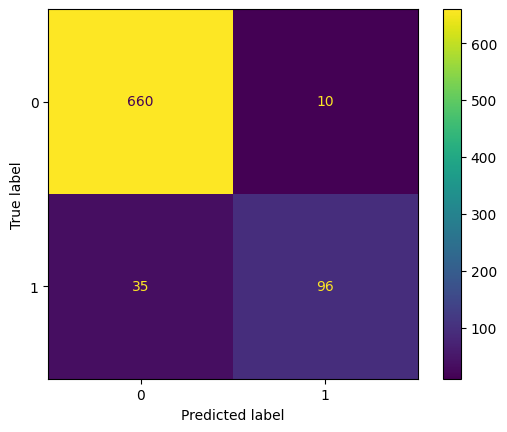

In [20]:
# Plot confusion matrix
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Save confusion matrix
plt.savefig(PROJECT_ROOT / "outputs" / "confusion_matrix.png", dpi=150, bbox_inches='tight', pad_inches=0)

*Attribution*:

- https://github.com/benckx/dnn-movie-posters
- https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
- https://www.kaggle.com/datasets/rounakbanik/pokemon